In [7]:

import pandas as pd
from numpy.random import randn, normal, uniform
import numpy as np
import random
from statistics import mean, stdev, median
import h2o
import os
import time
import math
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import cvxpy as cp
from scipy.optimize import minimize
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import inspect

from evaluation.helpers import mask, generate_LRGC
from em.low_rank_expectation_maximization import LowRankExpectationMaximization
from h2o.estimators import H2OGeneralizedLowRankEstimator
from glrm.loss import OrdinalLoss
from glrm.reg import QuadraticReg
from glrm.glrm import GLRM
from glrm.convergence import Convergence
from glrm.util import pplot

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [3]:
import pyglrm

/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


## Data Processing

In [4]:
# Load data from file
loc = 'datasets/ml-100k/u.data'
names = ['user_id', 'movie_id', 'rating', 'timestamp']
data =  pd.read_csv(loc, sep="\t", header=None, names = names)

In [5]:
data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
# Initialize empty array
A_orig = np.zeros((943, 1682))
data_indices_orig = []

# Populate data array
for index, row in data.iterrows():
    user = row['user_id'] - 1
    movie = row['movie_id'] - 1
    rating = row['rating']
    A_orig[user, movie] = rating
    data_indices_orig.append((user, movie))

In [10]:
# Load items from file
items_loc = "datasets/ml-100k/u.item"
items_headings = ["movie id", "movie title", "release date", "video release date", "IMDb URL", \
                  "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", \
                  "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", \
                  "Romance", "Sci-Fi", "Thriller", "War", "Western"]
items =  pd.read_csv(items_loc, sep="|", header=None, names=items_headings, encoding='latin-1')

In [11]:
genres = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", \
          "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", \
          "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [12]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Reduce dataset

In [13]:
A = A_orig.copy()
cols_to_delete = []
for i, row in enumerate(A_orig.T):
    if np.count_nonzero(row) < 20:
        cols_to_delete.append(i)
A = np.delete(A, cols_to_delete, 1)

In [14]:
# Track correspondence of array columns to movie id
movie_id_correspondence = {}

tmp_id = 0
for i in range(1682):
    if i not in cols_to_delete:
        movie_id_correspondence[tmp_id] = i
        tmp_id += 1

In [15]:
# Record indices where data is missing and where it exists

missing_indices = []
data_indices = []
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        if A[i, j] == 0:
            missing_indices.append((i, j))
        else:
            data_indices.append((i, j))

In [16]:
# Convert all missing fields to NAN
for index in missing_indices:
    A[index[0], index[1]] = np.nan

# Impute with LRGC

In [80]:
k_model = 4
lrgc_model = LowRankExpectationMaximization()
lrgc_A_imp, _, _ = lrgc_model.impute_missing(A, k_model, verbose=True)

sigma estimate: 0.8345025865312097
log likelihood: 44476.53242554214
Updated error: 0.2987629643020034
sigma estimate: 0.7618299292548449
log likelihood: 88031.86884888758
Updated error: 0.1313161136288033
sigma estimate: 0.7227511879023829
log likelihood: 112040.87491849066
Updated error: 0.08484104023873357
sigma estimate: 0.6976411695721003
log likelihood: 128151.94715161424
Updated error: 0.06518690255313946
sigma estimate: 0.6793626146403732
log likelihood: 140231.1355693327
Updated error: 0.0529914747629899
sigma estimate: 0.6654861119464383
log likelihood: 149615.6233028635
Updated error: 0.04451877609404502
sigma estimate: 0.6548517449587885
log likelihood: 156940.793851369
Updated error: 0.03849042951956536
sigma estimate: 0.6467004220340233
log likelihood: 162637.89862824525
Updated error: 0.03409876127555726
sigma estimate: 0.6404628917313111
log likelihood: 167047.87467941007
Updated error: 0.030780322796091983
sigma estimate: 0.6356961145467944
log likelihood: 170448.78689

In [81]:
# Save imputed array to prevent sadness later on
np.save("imputation_exp_outputs/visualize_movie100k/lrgc_A_imp_4_v2.npy", lrgc_A_imp)

In [82]:
lrgc_A_imp = np.load("imputation_exp_outputs/visualize_movie100k/lrgc_A_imp_4.npy")

# Impute with GLRM

In [17]:
glrm_k_model = 6

In [18]:
def to_ord(X):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = X[i, j]
            if x > 5:
                X[i, j] = 5
            elif x < 1:
                X[i, j] = 1
            else:
                X[i, j] = int(round(X[i, j])) 

In [34]:
glrm_loss = pyglrm.HingeLoss()
regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
glrm_model = pyglrm.glrm(glrm_loss, regX, regY, n_components=glrm_k_model, offset=True, scale=True)
glrm_A_imp = glrm_model.fit_impute(A)
to_ord(glrm_A_imp)

/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [35]:
# Save imputed array to prevent sadness later on
np.save("imputation_exp_outputs/visualize_movie100k/glrm_A_imp_v2.npy", glrm_A_imp)

# Get information of first few movies

In [44]:
# Visualize first few movies

sample_titles = []
sample_genres = []
for i in range(40):
    movie_id = movie_id_correspondence[i] + 1
    title = items.loc[items['movie id'] == movie_id, 'movie title'].iloc[0]
    genre_string = ""
    for genre in genres:
        if items.loc[items['movie id'] == movie_id, genre].iloc[0] == 1:
            genre_string += genre + '; '
    sample_genres.append(genre_string)
    sample_titles.append(title)
    
sample_title_to_genres = []
for title, genre in zip(sample_titles, sample_genres):
    sample_title_to_genres.append([title, genre])

In [46]:
print(tabulate(sample_title_to_genres, headers=['Title', 'Genre']))

Title                                                    Genre
-------------------------------------------------------  ---------------------------------------------
Toy Story (1995)                                         Animation; Children's; Comedy;
GoldenEye (1995)                                         Action; Adventure; Thriller;
Four Rooms (1995)                                        Thriller;
Get Shorty (1995)                                        Action; Comedy; Drama;
Copycat (1995)                                           Crime; Drama; Thriller;
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)     Drama;
Twelve Monkeys (1995)                                    Drama; Sci-Fi;
Babe (1995)                                              Children's; Comedy; Drama;
Dead Man Walking (1995)                                  Drama;
Richard III (1995)                                       Drama; War;
Seven (Se7en) (1995)                                     Crime; Thriller;
Usual

# Visualize correlation between the imputed ratings of different titles

## LRGC

In [392]:
sample_movies_df_lrgc = pd.DataFrame(data=lrgc_A_imp[:, :40], columns=sample_titles)

In [393]:
sample_movies_corr_matrix_lrgc = sample_movies_df_lrgc.corr(method='spearman')

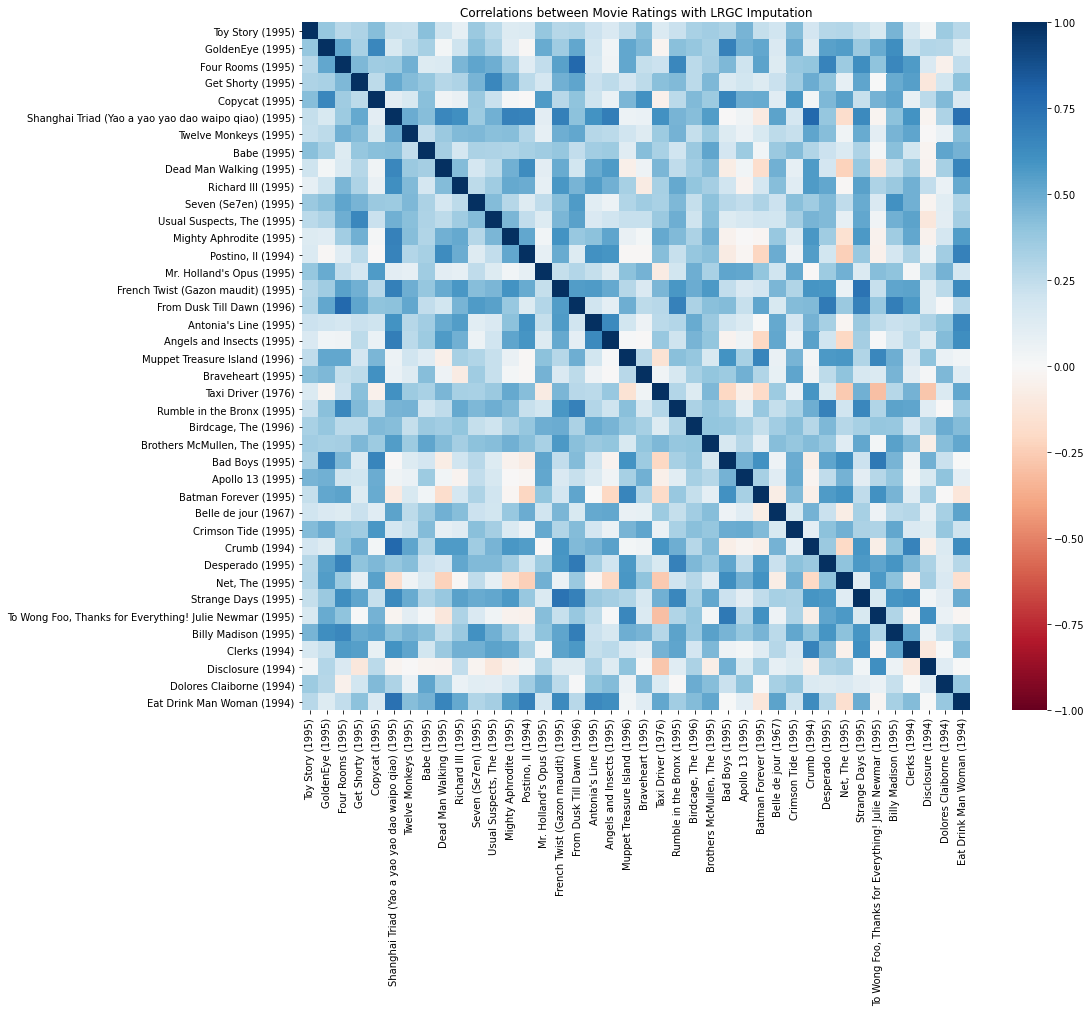

In [394]:
# vmin and vmax control the range of the colormap
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(sample_movies_corr_matrix_lrgc, cmap='RdBu', vmin=-1, vmax=1)
plt.tight_layout()
plt.title("Correlations between Movie Ratings with LRGC Imputation")
plt.savefig("imputation_exp_outputs/visualize_movie100k/corr_lrgc_impute_4.pdf")

## GLRM

In [70]:
sample_movies_df_glrm = pd.DataFrame(data=glrm_A_imp[:, :40], columns=sample_titles)

In [71]:
sample_movies_corr_matrix_glrm = sample_movies_df_glrm.corr(method='spearman')

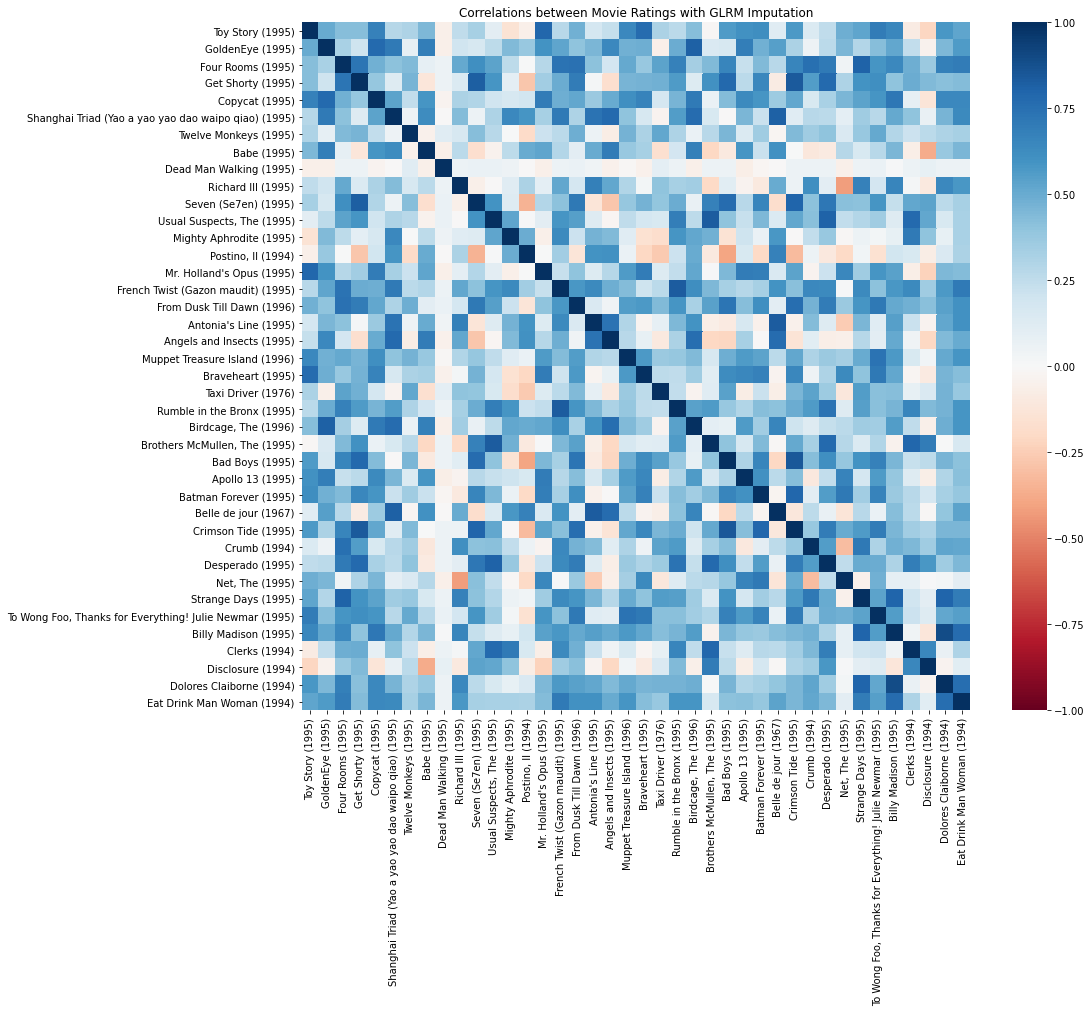

In [72]:
# vmin and vmax control the range of the colormap
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(sample_movies_corr_matrix_glrm, cmap='RdBu', vmin=-1, vmax=1)
plt.tight_layout()
plt.title("Correlations between Movie Ratings with GLRM Imputation")
plt.savefig("imputation_exp_outputs/visualize_movie100k/corr_glrm_impute.pdf")

# Compare genre scores of observed and imputed data 

In [384]:
row_id = 3

In [385]:
genre_scores_orig = [[] for i in range(19)]
genre_scores_imp_lrgc = [[] for i in range(19)]
genre_scores_imp_glrm = [[] for i in range(19)]

for j in range(A.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    orig_score = A[row_id, j]
    lrgc_imp_score = lrgc_A_imp[row_id, j]
    glrm_imp_score = glrm_A_imp[row_id, j]
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            if math.isnan(orig_score):
                genre_scores_imp_lrgc[k].append(lrgc_imp_score)
                genre_scores_imp_glrm[k].append(glrm_imp_score)
            else:
                genre_scores_orig[k].append(orig_score)

In [386]:
genre_titles_obs = []
mean_genre_scores_orig = []
std_genre_scores_orig = []
mean_genre_scores_imp_lrgc = []
std_genre_scores_imp_lrgc = []
mean_genre_scores_imp_glrm = []
std_genre_scores_imp_glrm = []

for i in range(19):
    if len(genre_scores_orig[i]) > 1:
        genre_titles_obs.append(genres[i])
        mean_genre_scores_orig.append(mean(genre_scores_orig[i]))
        std_genre_scores_orig.append(stdev(genre_scores_orig[i]))
        mean_genre_scores_imp_lrgc.append(mean(genre_scores_imp_lrgc[i]))
        std_genre_scores_imp_lrgc.append(stdev(genre_scores_imp_lrgc[i]))
        mean_genre_scores_imp_glrm.append(mean(genre_scores_imp_glrm[i]))
        std_genre_scores_imp_glrm.append(stdev(genre_scores_imp_glrm[i]))

## LRGC

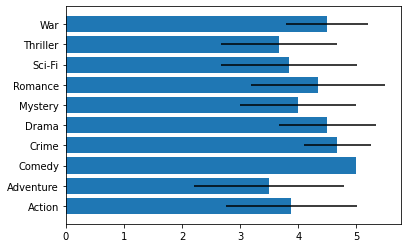

In [387]:
plt.barh(genre_titles_obs, mean_genre_scores_orig, xerr=std_genre_scores_orig)
plt.show()

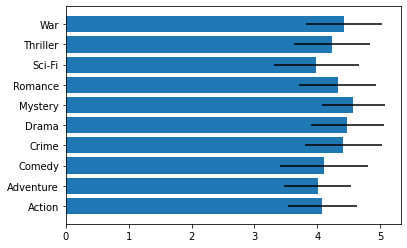

In [388]:
plt.barh(genre_titles_obs, mean_genre_scores_imp_lrgc, xerr=std_genre_scores_imp_lrgc)
plt.show()

## GLRM

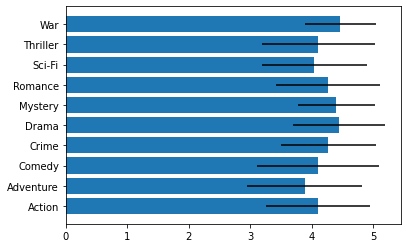

In [389]:
plt.barh(genre_titles_obs, mean_genre_scores_imp_glrm, xerr=std_genre_scores_imp_glrm)
plt.show()

# Cluster

In [186]:
def sumorderr(A, A_hat, all_thresh=True): 
    A_diff = np.abs(A - A_hat)
    if all_thresh is True:
        return np.sum(np.vectorize(cumu_sum)(A_diff))
    else:
        return np.sum(A_diff)

def cumu_sum(x):
    return sum(i+1 for i in range(int(x)))

## LRGC K-medoids

In [395]:
# Decide on number of clusters
nc_test = [1, 2, 3, 4, 5, 6, 7, 8, 9]
nc_test_inertias_lrgc = []
for nc in nc_test:
    nc_test_kmedoids_lrgc = KMedoids(n_clusters=nc, metric=sumorderr, init='k-medoids++', random_state=0).fit(lrgc_A_imp)
    nc_test_inertias_lrgc.append(nc_test_kmedoids_lrgc.inertia_)
    print('nc={} complete'.format(nc))

nc=1 complete
nc=2 complete
nc=3 complete
nc=4 complete
nc=5 complete
nc=6 complete
nc=7 complete
nc=8 complete
nc=9 complete


In [396]:
nc_test_inertias_lrgc

[470512.0,
 402333.0,
 368847.0,
 349176.0,
 361969.0,
 329712.0,
 325152.0,
 317659.0,
 309271.0]

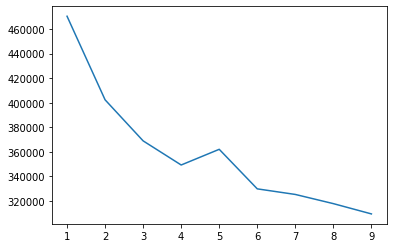

In [397]:
plt.plot(np.arange(1, 10), nc_test_inertias_lrgc)
plt.show()

In [398]:
n_clusters = 4

In [399]:
start_time = time.time()
kmedoids_lrgc = KMedoids(n_clusters=n_clusters, metric=sumorderr, init='k-medoids++', random_state=0).fit(lrgc_A_imp)
end_time = time.time()
print("K-medoids clustering for LRGC model finished in {} ns".format(end_time - start_time))

K-medoids clustering for LRGC model finished in 251.41738629341125 ns


In [217]:
# Continue from here
kmedoids_lrgc_cc = kmedoids_lrgc.cluster_centers_

In [218]:
kmedoids_lrgc.inertia_

387942.0

In [219]:
kmedoids_lrgc_cc_genre_scores = [[[] for j in range(19)] for i in range(n_clusters)]

for j in range(lrgc_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(n_clusters):
                kmedoids_lrgc_cc_genre_scores[i][k].append(kmedoids_lrgc_cc[i, j])

In [231]:
kmedoids_lrgc_cc_genre_scores_mean = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmedoids_lrgc_cc_genre_scores]

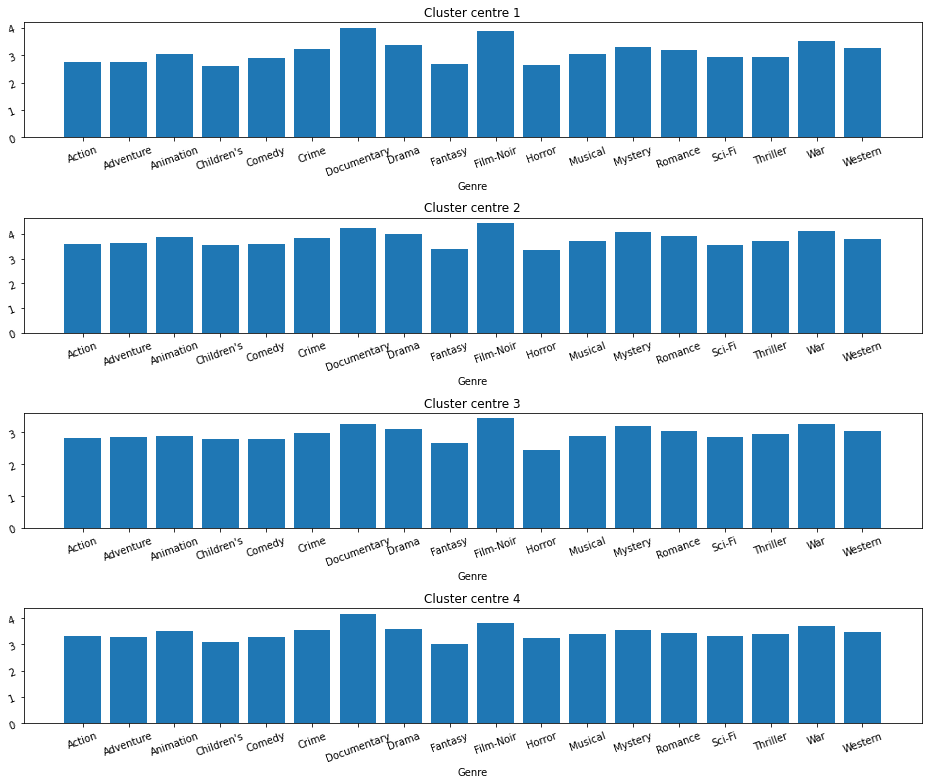

In [282]:
# Visualise the meaning of these cluster centres
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,11))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmedoids_lrgc_cc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/lrgc_ccs_kmedoids_bygenre.pdf")

In [225]:
kmedoids_lrgc_cc[0][:20]

array([3., 3., 2., 3., 3., 4., 4., 4., 4., 4., 3., 4., 4., 4., 3., 3., 2.,
       4., 4., 2.])

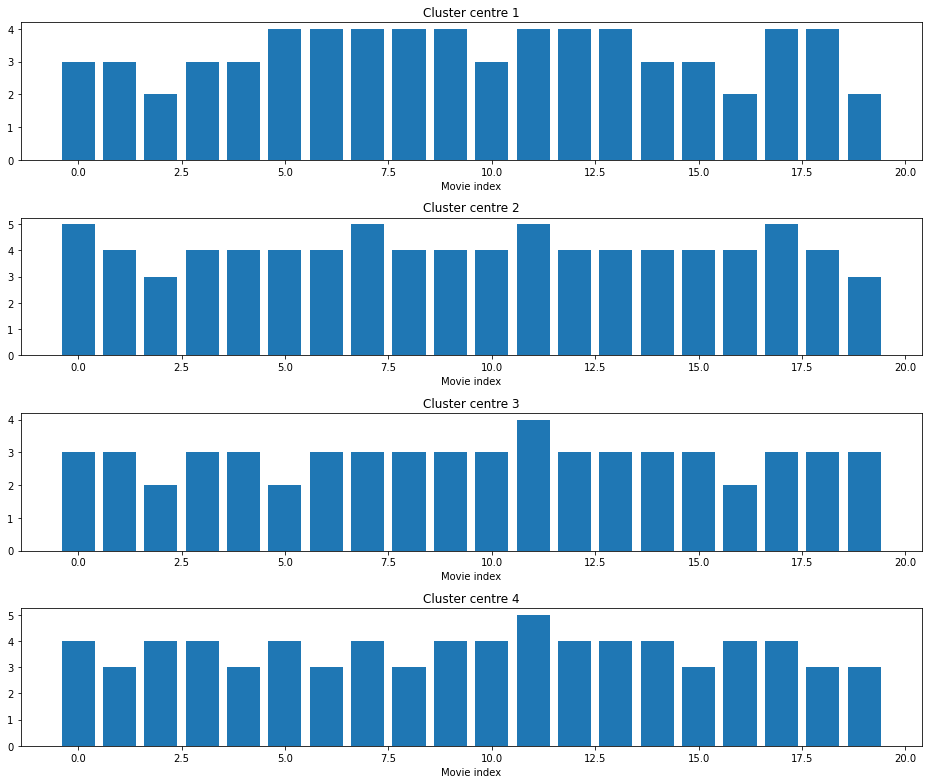

In [283]:
# Visualise the meaning of these cluster centres
#tick_labels = np.arange(21)
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,11))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.bar(range(20), kmedoids_lrgc_cc[i][:20])
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/lrgc_ccs_kmedoids_bymovie.pdf")

## GLRM K-means

In [39]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 10)
nc_test_inertias_glrm_kmeans = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans_glrm = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans_glrm.fit(glrm_model.X.T)
    
    # Append the inertia to the list of inertias
    nc_test_inertias_glrm_kmeans.append(kmeans_glrm.inertia_)

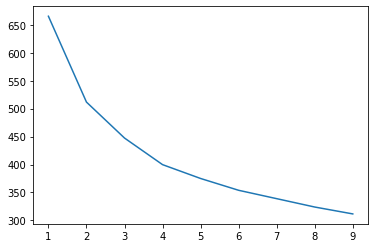

In [40]:
plt.plot(np.arange(1, 10), nc_test_inertias_glrm_kmeans)
plt.show()

In [107]:
n_clusters = 4

In [108]:
kmeans_glrm = KMeans(n_clusters=n_clusters)
kmeans_glrm.fit(glrm_model.X.T)

KMeans(n_clusters=4)

In [109]:
kmeans_glrm_cc = kmeans_glrm.cluster_centers_.dot(glrm_model.Y)

In [110]:
kmeans_glrm_cc

array([[3.90855623, 3.08740029, 3.06072967, ..., 3.0096643 , 2.12478618,
        2.67559005],
       [3.11824298, 2.13145958, 2.22020599, ..., 3.01860809, 2.03097073,
        2.61539484],
       [3.75636514, 3.23889673, 2.70126271, ..., 3.00474027, 2.16489722,
        1.02133454],
       [4.44742252, 3.89867836, 3.55933334, ..., 3.01376188, 2.05982109,
        2.80798645]])

In [111]:
kmeans_glrm_cc_genre_scores = [[[] for j in range(19)] for i in range(n_clusters)]

for j in range(glrm_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(n_clusters):
                kmeans_glrm_cc_genre_scores[i][k].append(kmeans_glrm_cc[i, j])

In [112]:
kmeans_glrm_cc_genre_scores_mean = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmeans_glrm_cc_genre_scores]

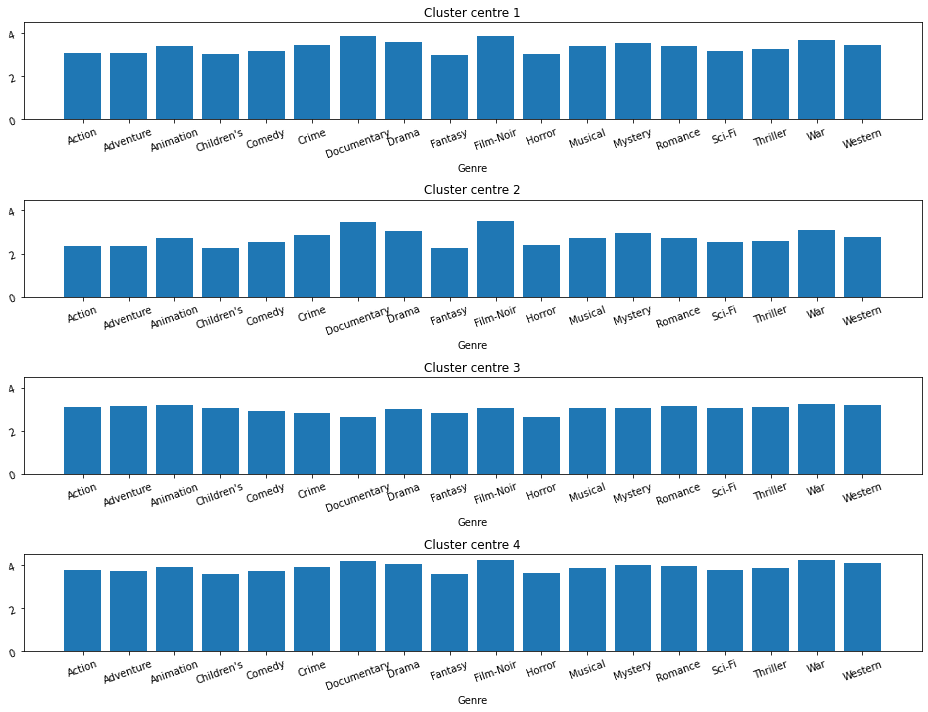

In [118]:
# Visualise the genres corresponding to these cluster centres v2
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,10))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.set_ylim([0,4.5])
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_cc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ccs_kmeans_bygenre_v3.pdf")

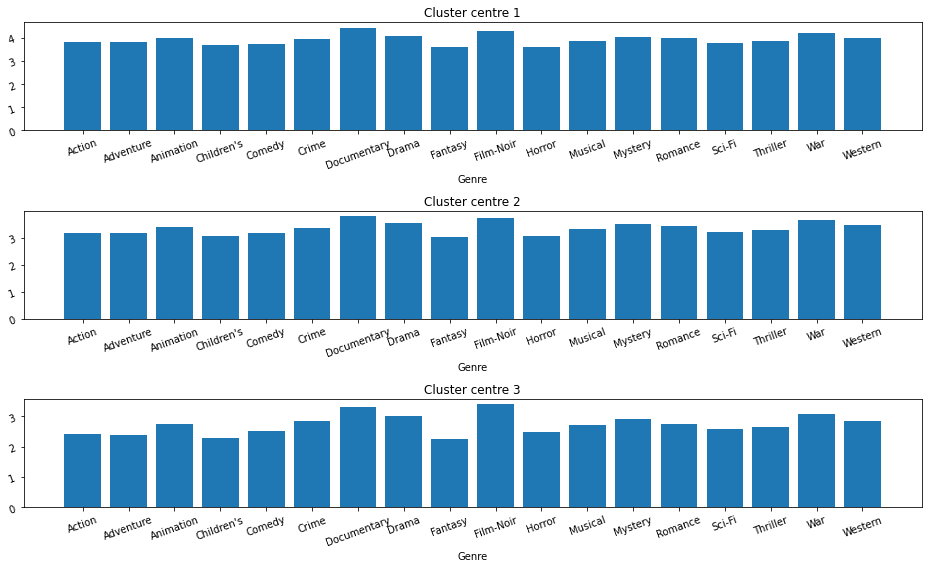

In [279]:
# Visualise the genres corresponding to these cluster centres
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,8))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_cc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ccs_kmeans_bygenre.pdf")

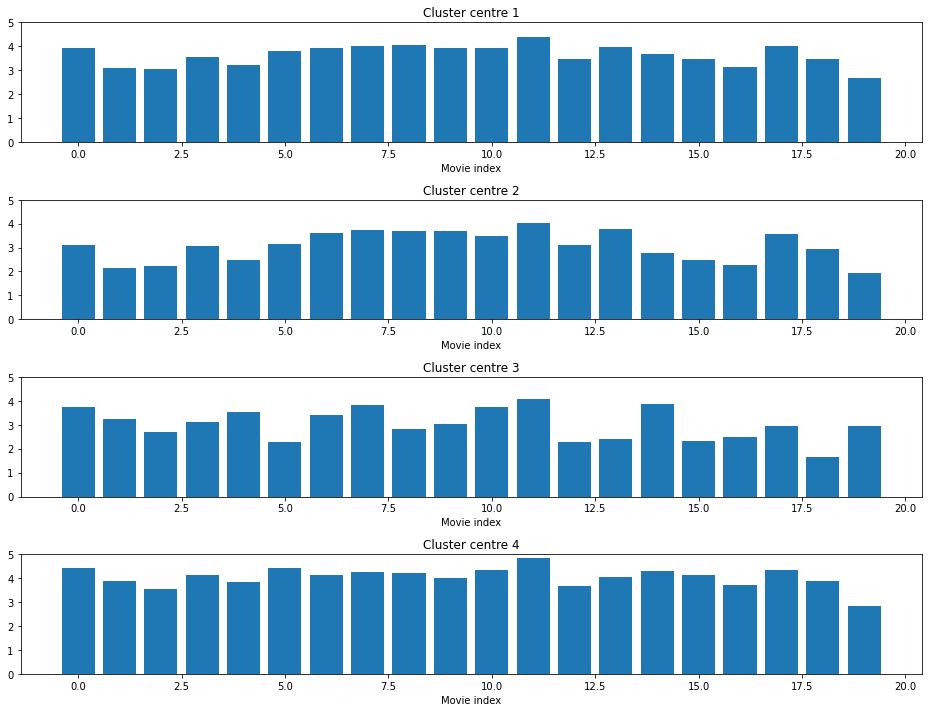

In [124]:
# Visualise these cluster centres
#tick_labels = np.arange(21)
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,10))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.set_ylim([0,5])
    ax.bar(range(20), kmeans_glrm_cc[i][:20])
plt.tight_layout()
#plt.show()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ccs_kmeans_bymovie_v3.pdf")

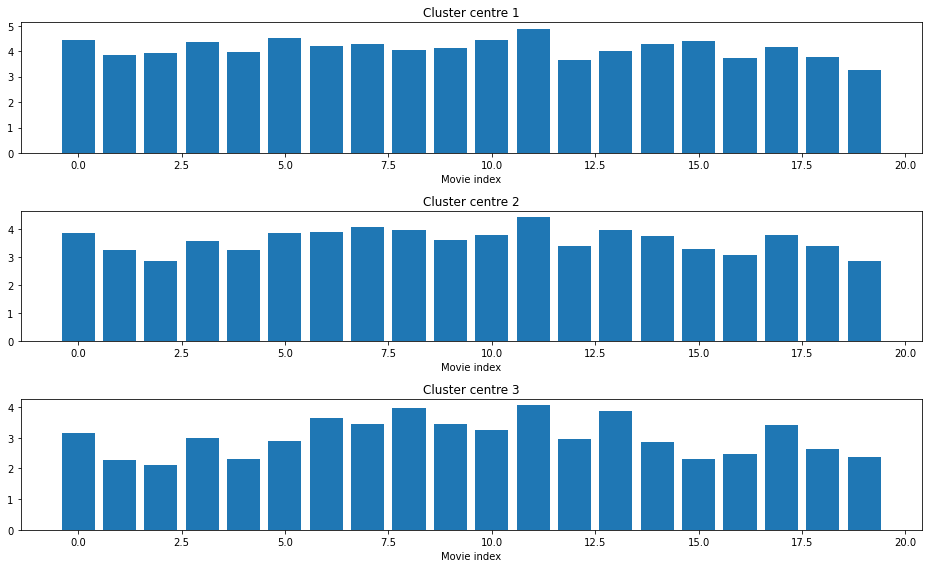

In [280]:
# Visualise these cluster centres
#tick_labels = np.arange(21)
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,8))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.bar(range(20), kmeans_glrm_cc[i][:20])
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ccs_kmeans_bymovie.pdf")

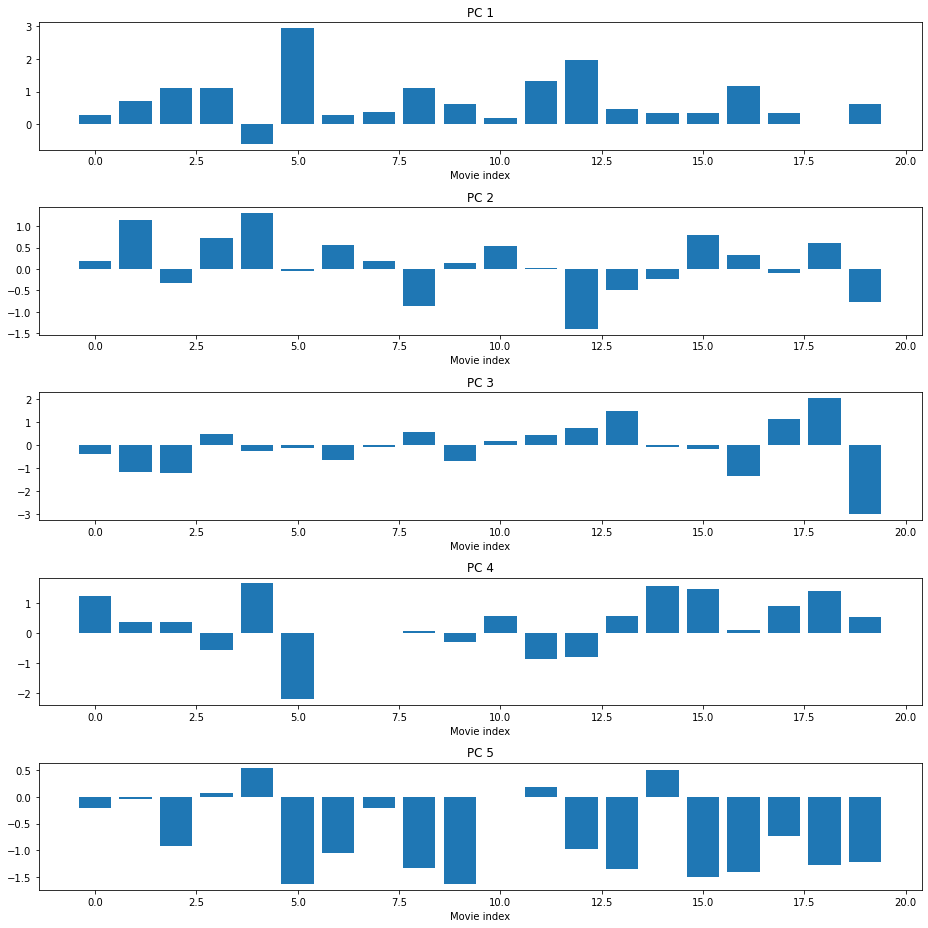

In [79]:
# Visualise the principal components v2
#tick_labels = np.arange(21)
fig, axs = plt.subplots(5, 1, figsize=(13,13))
for i, ax in enumerate(axs):
    ax.set_title("PC {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.bar(range(20), glrm_model.Y[i][:20])
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_pcs_bymovie_v2.pdf")

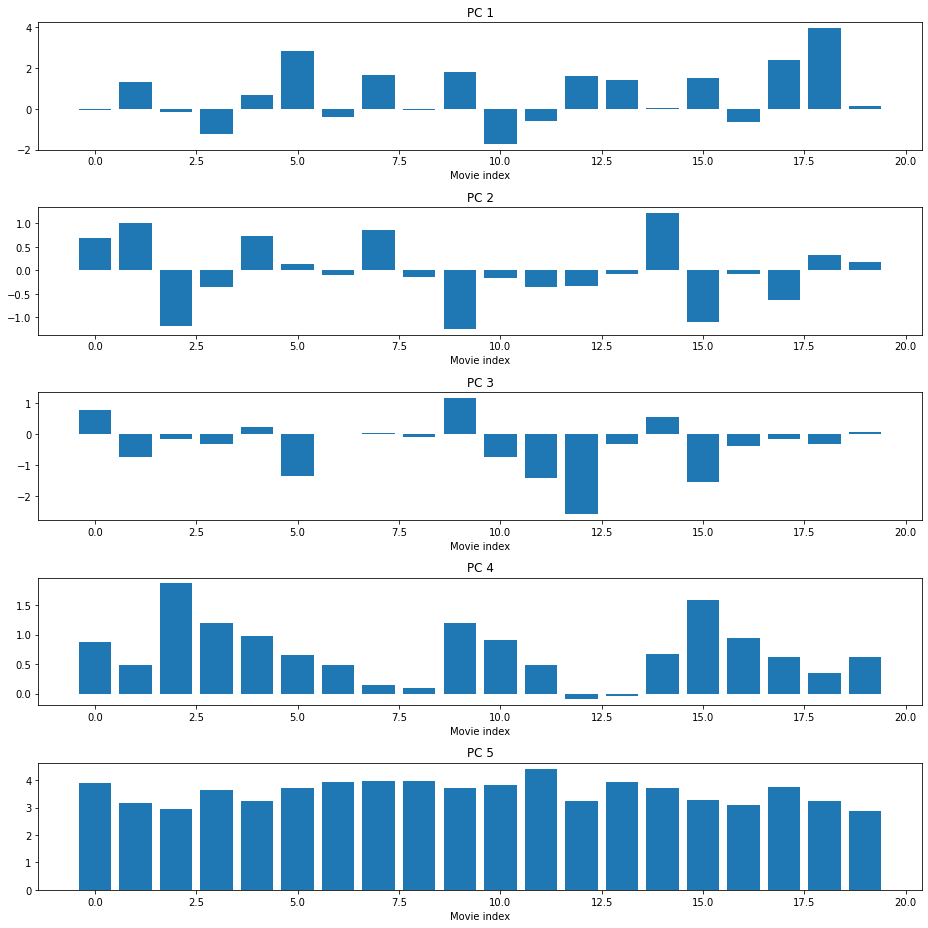

In [272]:
# Visualise the principal components
#tick_labels = np.arange(21)
fig, axs = plt.subplots(5, 1, figsize=(13,13))
for i, ax in enumerate(axs):
    ax.set_title("PC {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.bar(range(20), glrm_model.Y[i][:20])
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_pcs_bymovie.pdf")

In [37]:
# Visualize the principal components by genre

kmeans_glrm_pc_genre_scores = [[[] for j in range(19)] for i in range(5)]

for j in range(glrm_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(5):
                kmeans_glrm_pc_genre_scores[i][k].append(glrm_model.Y[i, j])
                
kmeans_glrm_pc_genre_scores_mean = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmeans_glrm_pc_genre_scores]

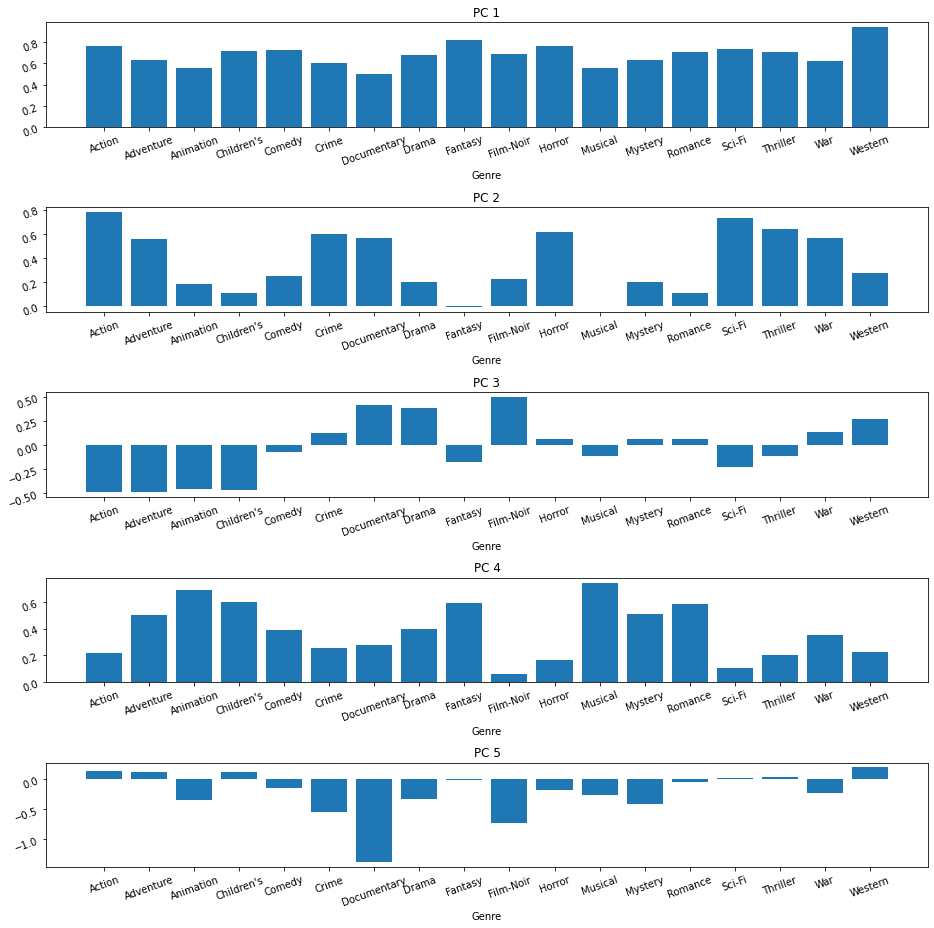

In [51]:
# Visualise the meaning of these cluster centres v2 NEWNEW HERE
tick_labels = genres[1:]
fig, axs = plt.subplots(5, 1, figsize=(13,13))
for i, ax in enumerate(axs):
    ax.set_title("PC {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_pc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_pcs_bygenre_v2.pdf")

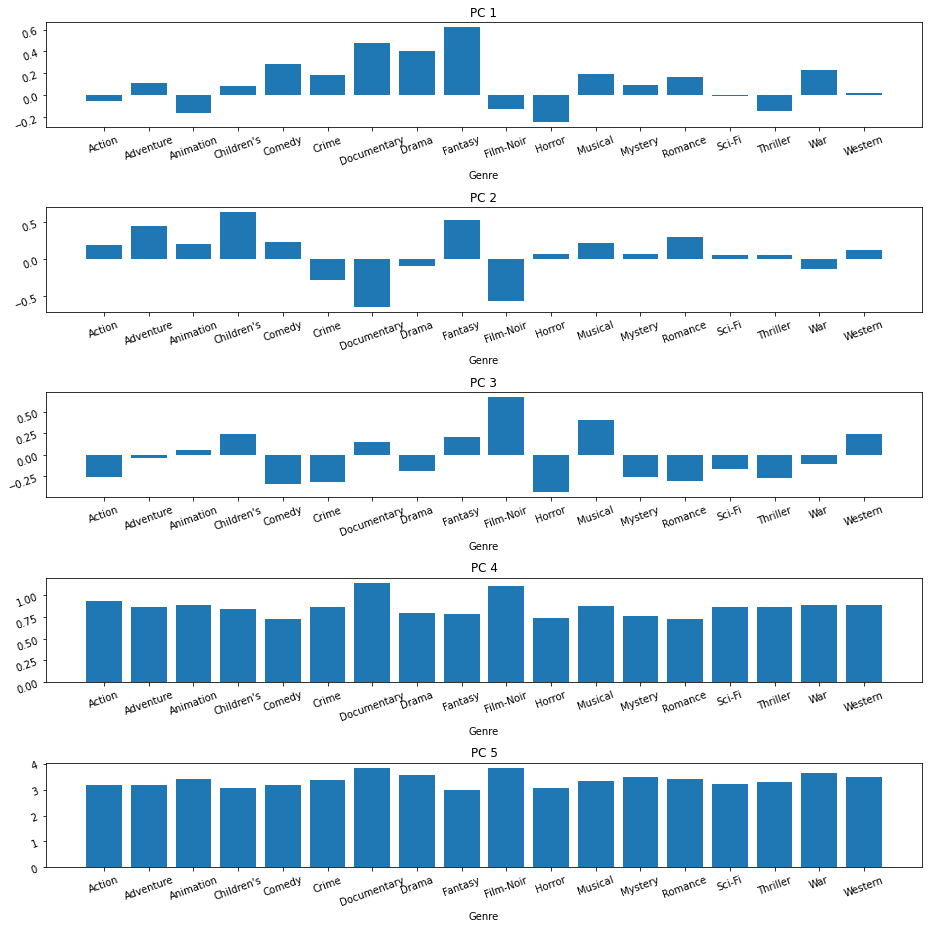

In [277]:
# Visualise the meaning of these cluster centres
tick_labels = genres[1:]
fig, axs = plt.subplots(5, 1, figsize=(13,13))
for i, ax in enumerate(axs):
    ax.set_title("PC {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_pc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_pcs_bygenre.pdf")

## Cluster with only PCs 2 to 5 for GLRM

In [60]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 10)
nc_test_inertias_glrm_kmeans_r = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans_glrm_r = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans_glrm_r.fit(glrm_model.X.T[:,1:])
    
    # Append the inertia to the list of inertias
    nc_test_inertias_glrm_kmeans_r.append(kmeans_glrm_r.inertia_)

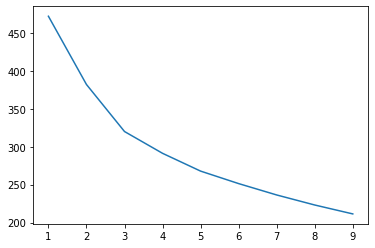

In [61]:
plt.plot(np.arange(1, 10), nc_test_inertias_glrm_kmeans_r)
plt.show()

In [62]:
n_clusters = 3
kmeans_glrm_r = KMeans(n_clusters=n_clusters)
kmeans_glrm_r.fit(glrm_model.X.T[:,1:])

KMeans(n_clusters=3)

In [67]:
kmeans_glrm_cc_r = kmeans_glrm_r.cluster_centers_.dot(glrm_model.Y[1:,:])

In [72]:
kmeans_glrm_cc_r

array([[3.82882427, 3.41431764, 2.88310464, ..., 3.00892846, 2.07787469,
        1.1614776 ],
       [3.52566318, 2.65540875, 2.95350252, ..., 3.0028199 , 1.97117654,
        2.30198685],
       [4.18597452, 3.38418583, 2.99389298, ..., 3.02061498, 2.23839264,
        3.21120945]])

In [69]:
kmeans_glrm_cc_genre_scores_r = [[[] for j in range(19)] for i in range(n_clusters)]

for j in range(glrm_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(n_clusters):
                kmeans_glrm_cc_genre_scores_r[i][k].append(kmeans_glrm_cc_r[i, j])

In [70]:
kmeans_glrm_cc_genre_scores_mean_r = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmeans_glrm_cc_genre_scores_r]

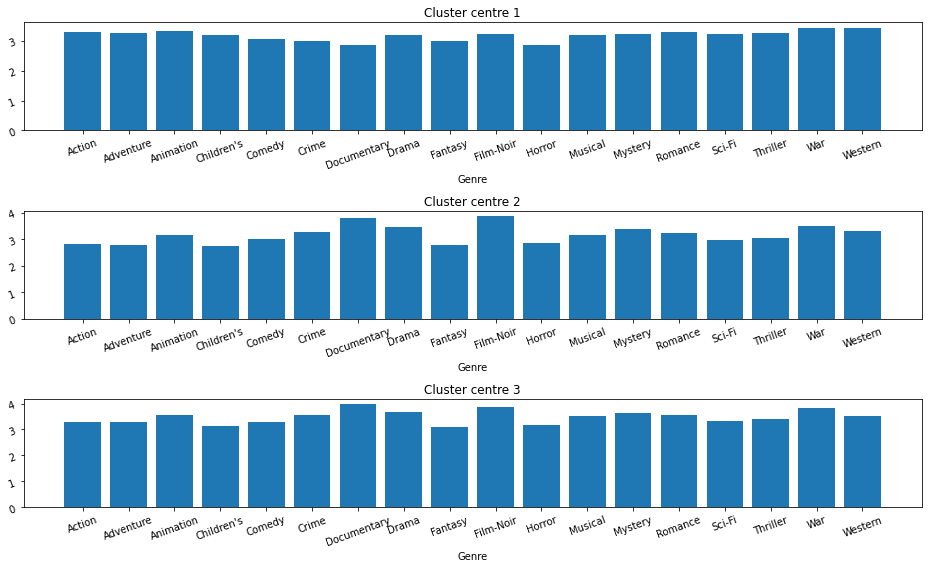

In [77]:
# Visualise the genres corresponding to these cluster centres v2
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,8))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_cc_genre_scores_mean_r[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ccs_kmeans_bygenre_r.pdf")

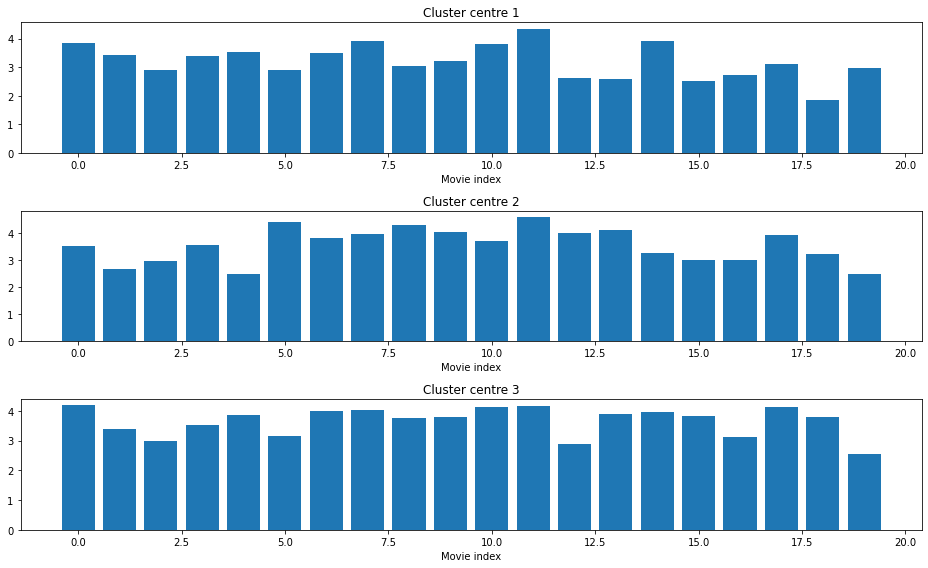

In [78]:
# Visualise these cluster centres
#tick_labels = np.arange(21)
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,8))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.bar(range(20), kmeans_glrm_cc_r[i][:20])
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ccs_kmeans_bymovie_r.pdf")

## LRGC standardize / mean-subtracted data k-means

In [325]:
# Run if want standardized
lrgc_A_imp_stdd = []
for i in range(lrgc_A_imp.shape[0]):
    cur_row = lrgc_A_imp[i]
    row_mean = mean(cur_row)
    row_std = stdev(cur_row)
    new_row = []
    for j in range(lrgc_A_imp.shape[1]):
        new_row.append((cur_row[j]-row_mean)/row_std)
    lrgc_A_imp_stdd.append(new_row)
lrgc_A_imp_stdd = np.array(lrgc_A_imp_stdd)

In [83]:
# Run if want mean subtracted
lrgc_A_imp_stdd = []
for i in range(lrgc_A_imp.shape[0]):
    cur_row = lrgc_A_imp[i]
    row_mean = mean(cur_row)
    new_row = []
    for j in range(lrgc_A_imp.shape[1]):
        new_row.append(cur_row[j]-row_mean)
    lrgc_A_imp_stdd.append(new_row)
lrgc_A_imp_stdd = np.array(lrgc_A_imp_stdd)

In [376]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 10)
nc_test_inertias_lrgc_normd_kmeans = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans_lrgc_normd = KMeans(n_clusters=k)
    # Fit model to samples
    
    #kmeans_lrgc_normd.fit(lrgc_A_imp_normd)
    kmeans_lrgc_normd.fit(lrgc_A_imp_stdd)
    
    # Append the inertia to the list of inertias
    nc_test_inertias_lrgc_normd_kmeans.append(kmeans_lrgc_normd.inertia_)

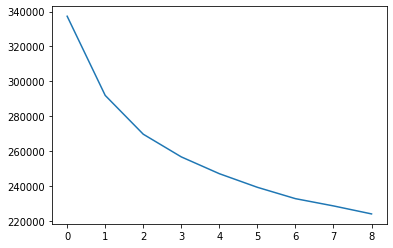

In [377]:
plt.plot(nc_test_inertias_lrgc_normd_kmeans)
plt.show()

In [378]:
n_clusters = 4

In [379]:
kmeans_lrgc_normd = KMeans(n_clusters=n_clusters)
#kmeans_lrgc_normd.fit(lrgc_A_imp_normd)
kmeans_lrgc_normd.fit(lrgc_A_imp_stdd)

KMeans(n_clusters=4)

In [380]:
kmeans_lrgc_normd_cc = kmeans_lrgc_normd.cluster_centers_

In [381]:
kmeans_lrgc_normd_cc_genre_scores = [[[] for j in range(19)] for i in range(n_clusters)]

for j in range(lrgc_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(n_clusters):
                kmeans_lrgc_normd_cc_genre_scores[i][k].append(kmeans_lrgc_normd_cc[i, j])

In [382]:
kmeans_lrgc_normd_cc_genre_scores_mean = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmeans_lrgc_normd_cc_genre_scores]

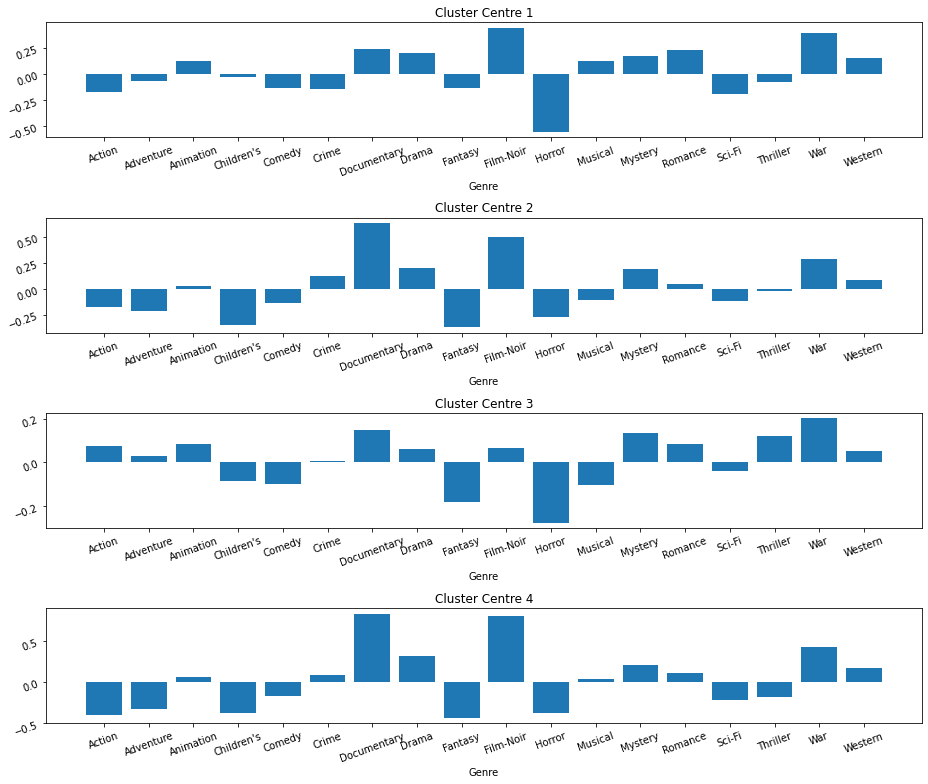

<Figure size 432x288 with 0 Axes>

In [383]:
# Visualise the meaning of these cluster centres
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,11))
for i, ax in enumerate(axs):
    ax.set_title("Cluster Centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_lrgc_normd_cc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
plt.show()
#plt.savefig("imputation_exp_outputs/visualize_movie100k/lrgc_stdd_ccs_kmeans_bygenre.pdf")
plt.savefig("imputation_exp_outputs/visualize_movie100k/lrgc_ms_ccs_kmeans_bygenre.pdf")

## LRGC imputation standardized, with PCA then K-means

In [ ]:
# Run if want mean subtracted
lrgc_A_imp_stdd = []
for i in range(lrgc_A_imp.shape[0]):
    cur_row = lrgc_A_imp[i]
    row_mean = mean(cur_row)
    new_row = []
    for j in range(lrgc_A_imp.shape[1]):
        new_row.append(cur_row[j]-row_mean)
    lrgc_A_imp_stdd.append(new_row)
lrgc_A_imp_stdd = np.array(lrgc_A_imp_stdd)

In [84]:
glrm_k_model=4
glrm_loss = pyglrm.QuadLoss()
regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
glrm_model_s = pyglrm.glrm(glrm_loss, regX, regY, n_components=glrm_k_model, offset=True, scale=True)
glrm_A_imp_s = glrm_model_s.fit_impute(lrgc_A_imp_stdd)

/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [85]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 10)
nc_test_inertias_glrm_kmeans_s = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans_glrm_s = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans_glrm_s.fit(glrm_model_s.X.T)
    
    # Append the inertia to the list of inertias
    nc_test_inertias_glrm_kmeans_s.append(kmeans_glrm_s.inertia_)

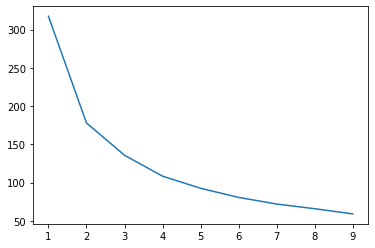

In [86]:
plt.plot(np.arange(1, 10), nc_test_inertias_glrm_kmeans_s)
plt.show()

In [88]:
n_clusters = 4
kmeans_glrm_s = KMeans(n_clusters=n_clusters)
kmeans_glrm_s.fit(glrm_model_s.X.T)

KMeans(n_clusters=4)

In [89]:
kmeans_glrm_cc_s = kmeans_glrm_s.cluster_centers_.dot(glrm_model_s.Y)

In [90]:
kmeans_glrm_cc_genre_scores_s = [[[] for j in range(19)] for i in range(n_clusters)]

for j in range(glrm_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(n_clusters):
                kmeans_glrm_cc_genre_scores_s[i][k].append(kmeans_glrm_cc_s[i, j])

In [91]:
kmeans_glrm_cc_genre_scores_mean_s = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmeans_glrm_cc_genre_scores_s]

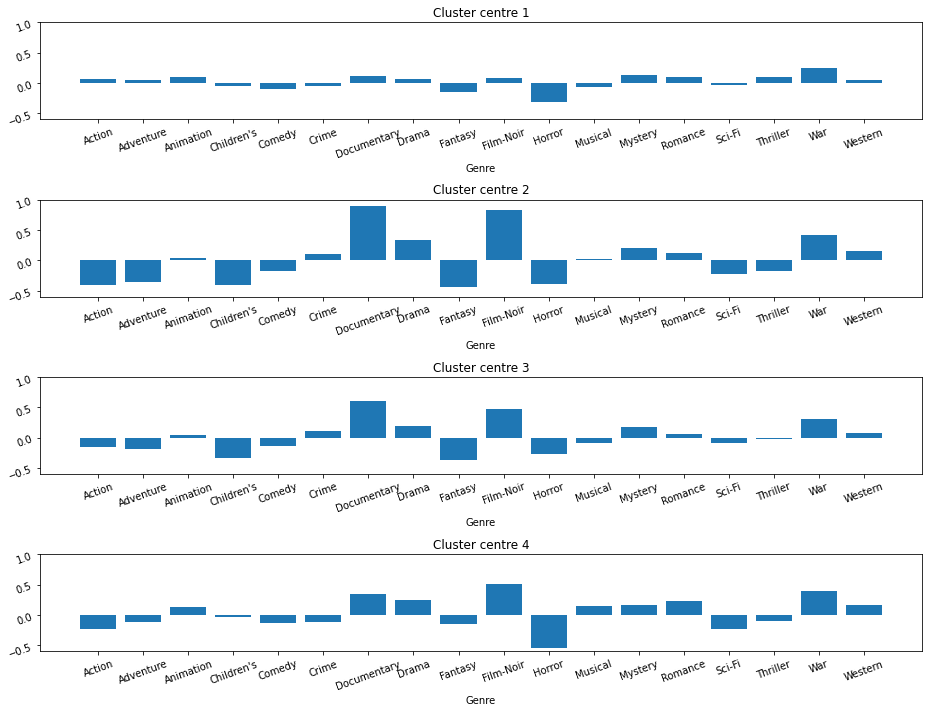

In [106]:
# Visualise the genres corresponding to these cluster centres v2
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,10))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.set_ylim([-0.6,1])
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_cc_genre_scores_mean_s[i], tick_label=tick_labels)
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/lrgc_ms_glrm_ccs_kmeans_bygenre.pdf")

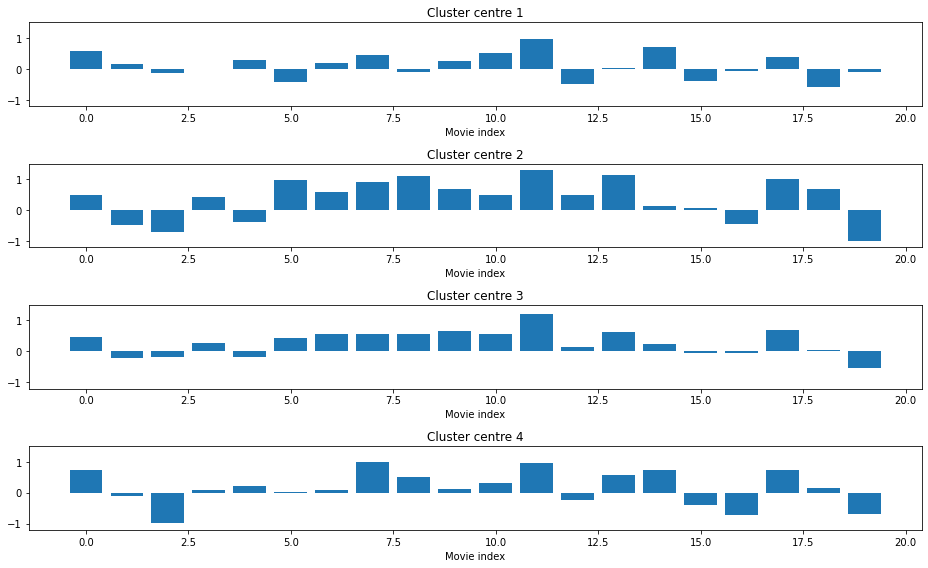

In [105]:
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,8))
for i, ax in enumerate(axs):
    ax.set_title("Cluster centre {}".format(i+1))
    ax.set_xlabel("Movie index")
    ax.set_ylim([-1.2,1.5])
    ax.bar(range(20), kmeans_glrm_cc_s[i][:20])
plt.tight_layout()
plt.savefig("imputation_exp_outputs/visualize_movie100k/lrgc_ms_glrm_ccs_kmeans_bymovie.pdf")

## GLRM standardize / mean-subtract k-means

In [354]:
# Run if want standardized
glrm_A_imp_stdd = []
for i in range(glrm_A_imp.shape[0]):
    cur_row = glrm_A_imp[i]
    row_mean = mean(cur_row)
    row_std = stdev(cur_row)
    new_row = []
    for j in range(glrm_A_imp.shape[1]):
        new_row.append((cur_row[j]-row_mean)/row_std)
    glrm_A_imp_stdd.append(new_row)
glrm_A_imp_stdd = np.array(glrm_A_imp_stdd)

In [365]:
# Run if want mean subtracted
glrm_A_imp_stdd = []
for i in range(glrm_A_imp.shape[0]):
    cur_row = glrm_A_imp[i]
    row_mean = mean(cur_row)
    new_row = []
    for j in range(glrm_A_imp.shape[1]):
        new_row.append((cur_row[j]-row_mean))
    glrm_A_imp_stdd.append(new_row)
glrm_A_imp_stdd = np.array(glrm_A_imp_stdd)

In [366]:
# Vary number of clusters to obtain cluster inertias, and determine optimal number of clusters

ks = range(1, 10)
nc_test_inertias_glrm_stdd_kmeans = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans_glrm_stdd = KMeans(n_clusters=k)
    # Fit model to samples
    kmeans_glrm_stdd.fit(glrm_A_imp_stdd)
    
    # Append the inertia to the list of inertias
    nc_test_inertias_glrm_stdd_kmeans.append(kmeans_glrm_stdd.inertia_)

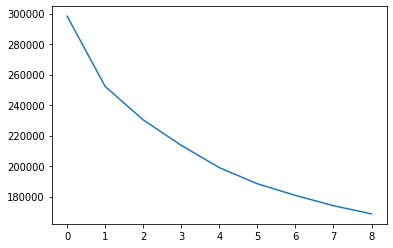

In [367]:
plt.plot(nc_test_inertias_glrm_stdd_kmeans)
plt.show()

In [368]:
n_clusters = 4

In [369]:
kmeans_glrm_stdd = KMeans(n_clusters=n_clusters)
#kmeans_lrgc_normd.fit(lrgc_A_imp_normd)
kmeans_glrm_stdd.fit(glrm_A_imp_stdd)

KMeans(n_clusters=4)

In [370]:
kmeans_glrm_stdd_cc = kmeans_glrm_stdd.cluster_centers_

In [371]:
kmeans_glrm_stdd_cc_genre_scores = [[[] for j in range(19)] for i in range(n_clusters)]

for j in range(glrm_A_imp.shape[1]):
    movie_id = movie_id_correspondence[j] + 1
    for k, genre in enumerate(genres):
        is_genre = items.loc[items['movie id'] == movie_id, genre].iloc[0]
        if is_genre == 1:
            for i in range(n_clusters):
                kmeans_glrm_stdd_cc_genre_scores[i][k].append(kmeans_glrm_stdd_cc[i, j])

In [372]:
kmeans_glrm_stdd_cc_genre_scores_mean = [[mean(gs[i]) for i in range(1, 19)] \
                                      for gs in kmeans_glrm_stdd_cc_genre_scores]

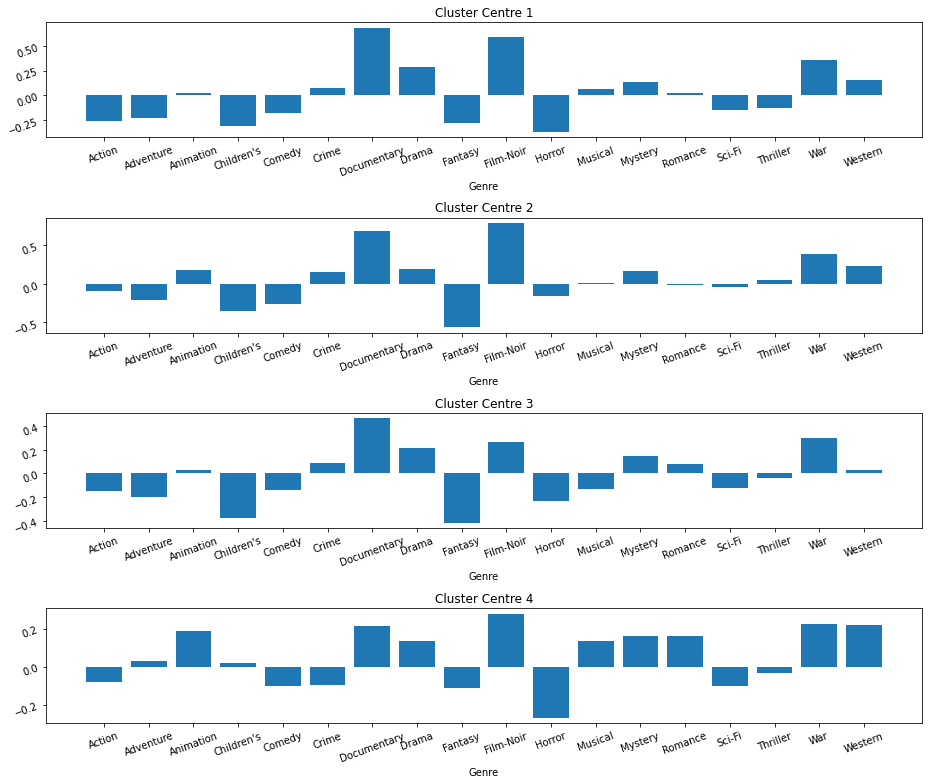

In [374]:
# Visualise the meaning of these cluster centres
tick_labels = genres[1:]
fig, axs = plt.subplots(n_clusters, 1, figsize=(13,11))
for i, ax in enumerate(axs):
    ax.set_title("Cluster Centre {}".format(i+1))
    ax.set_xlabel("Genre")
    ax.tick_params(labelrotation=20)
    ax.bar(range(18), kmeans_glrm_stdd_cc_genre_scores_mean[i], tick_label=tick_labels)
plt.tight_layout()
#plt.show()
#plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_stdd_ccs_kmeans_bygenre.pdf")
plt.savefig("imputation_exp_outputs/visualize_movie100k/glrm_ms_ccs_kmeans_bygenre.pdf")